# Comparison of IV and CCH method on hippocampal data with optical stimulation of pyramidal neurons

Data kindly provided by Sam McKenzie and Daniel Fine English.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from method import IV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import quantities as pq
import seaborn as sns
import sys
sys.path.append('../exana/'),
from exana.stimulus import plot_psth
from exana.statistics.plot import plot_xcorr, plot_autocorr
from exana.statistics.tools import ccg_significance, correlogram, ccg
from method import IV

import pandas as pd
import scipy
import neo
import exana

import pdb
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt

import requests
import os

import tools_experimentaldata as tls_exp
from method import IV

from tools_plot import savefig, fix_figure, set_style, despine
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy import fftpack
from exana.statistics.tools import hollow_kernel as hk
from itertools import chain
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def set_style(style='article', sns_style='white', w=1, h=1):
    sdict = {
        'article': {
            # (11pt font = 360pt, 4.98) (10pt font = 345pt, 4.77)                                                                                                                                                                                                                         
            'figure.figsize' : (4.98 * w, 2 * h),
            'figure.autolayout': False,
            'lines.linewidth': 2,
            'font.size'      : 11,
            'legend.frameon' : False,
            'legend.fontsize': 11,
            'font.family'    : 'serif',
            'text.usetex'    : True
        },
        'notebook': {
            'figure.figsize' : (16, 9),
            'axes.labelsize' : 50,
            'lines.linewidth': 4,
            'lines.markersize': 20,
            'xtick.labelsize': 30,
            'ytick.labelsize': 30,
            'axes.titlesize' : 20,
            'font.size'      : 20,
            'legend.frameon' : False,
            'legend.fontsize': 35,
            'font.family'    : 'serif',
            'text.usetex'    : True
        }
    }
    rc = sdict[style]
    plt.rcParams.update(rc)
    sns.set(rc=rc, style=sns_style,
            color_codes=True)
set_style('article')

In [2]:
# Load params
from params_experimentaldata import *
# update figure settings



In [3]:
units_db = tls_exp.load_unitlabels('optoLabels.mat', data_dir)
df_tmp = units_db.drop_duplicates(['animal', 'date'])
relevant_data = df_tmp.groupby('animal')['date'].apply(list).to_dict()

for animal_i in relevant_data.keys():
    for date_i in relevant_data[animal_i]:
        for entry in blk_blacklist:
            if animal_i == entry['animal'] and date_i == entry['date']:
                relevant_data[animal_i].remove(entry['date'])
            

In [4]:
relevant_data

{'camkii2': ['20160421'],
 'camkii3': ['20160504',
  '20160509',
  '20160510',
  '20160511',
  '20160518',
  '20160621',
  '20160506'],
 'camkii4': ['20160815', '20160817', '20160823', '20160824'],
 'camkii5': ['20160930', '20161004', '20160921']}

In [5]:
load_orig_files = False

if load_orig_files:
    tls_exp.download_files_by_dict(relevant_data,
                                   data_dir,
                                   n_shanks,
                                   files_ext_general,
                                   files_ext_by_shank,
                                   link_db)

    blks = tls_exp.create_neo_structure(relevant_data,
                                        data_dir,
                                        n_shanks,
                                        sampling_rate,
                                        unit_spiketime)

    tls_exp.add_stimulation_data_to_blocks(blks)
    tls_exp.annotate_units_from_db(units_db, blks)

else:
    blks = []
    for animal in relevant_data.keys():
        for date in relevant_data[animal]:
            nio = neo.io.PickleIO(data_dir + 'neo_files/' + animal + '_' + date + '.pckl')
            blk = nio.read_block()
            blks.append(blk)

In [6]:
blks = tls_exp.select_blocks_upon_stimtype(blks,
    stimtype='pulse', min_intens=1)

/home/jovyan/work/instrumentalVariable/causal-optoconnectics/tools_experimentaldata.py:1141: RuntimeWarning: invalid value encountered in greater_equal
  sel.append(epc.annotations['intensity'] >= min_intens)


## Determine which stimulations intensities have a significant effect  on units
We a) group very similar stimulations intensities and b) test whether intensity group has a significant effect on increasing spiking probability of any of the given units by convolving stimulation onsets with spike train.
We use the activity before a stimulation as baseline.


In [7]:
blks = tls_exp.group_stimulations(blks,
                                  sep_bins,
                                  sep_kernel_width,
                                  sep_threshold)

In [8]:
df_stim = tls_exp.find_significant_stimulations(blks,
   stimccg_binsize,
   stimccg_limit,
   stimccg_pthres,
   condition_annot_unit={'tagged': True})

  0%|          | 0/53 [00:00<?, ?it/s]

camkii4 20160817
Shank: 1
Shank: 3
camkii4 20160823
Shank: 3
Group: 0 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 4 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Shank: 4
Group: 0 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 4 of 5


  0%|          | 0/51 [00:00<?, ?it/s]

camkii4 20160824
Shank: 1
Shank: 2
Shank: 4
Group: 0 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 1 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 2 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 3 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 4 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 5 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 6 of 7


  0%|          | 0/40 [00:00<?, ?it/s]

camkii5 20160930
Shank: 1
Group: 0 of 1


  0%|          | 0/40 [00:00<?, ?it/s]

Shank: 2
Group: 0 of 1


  0%|          | 0/25 [00:00<?, ?it/s]

camkii5 20161004
Shank: 1
Group: 0 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 1 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 2 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 3 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 4 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 5 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Shank: 2
Group: 0 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 4 of 5


100%|██████████| 16/16 [00:00<00:00, 49563.42it/s]

camkii5 20160921
Shank: 4
Group: 0 of 5
Group: 1 of 5
Group: 2 of 5
Group: 3 of 5
Group: 4 of 5


### Example plot of  stimulation response

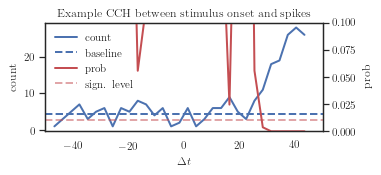

In [104]:
fig, ax = plt.subplots(1)
row_sel = 2
ln0 = ax.plot(df_stim.loc[row_sel]['bins'],
        df_stim.loc[row_sel]['cch'],
       label='count')
ln1 = ax.axhline(df_stim.loc[row_sel]['rate_baseline'],
           label='baseline',
          linestyle='--')
ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel(r'count')
ax2 = ax.twinx()
ln2 = ax2.plot(df_stim.loc[row_sel]['bins'],
         df_stim.loc[row_sel]['pfast'], c='r',
        label='prob')
ln3 = ax2.axhline(stimccg_pthres, c='r', linestyle='--',alpha=0.5, label='sign. level')
ax2.set_ylabel(r'prob')

ax2.set_ylim(0, 0.1)
ax.set_xlim(-50., 50.)
ax2.set_xlim(-50., 50.)

ln = ln0+[ln1]+ln2+[ln3]
labs = [l.get_label() for l in ln]
ax.legend(ln, labs, loc=0)
ax.set_title('Example CCH between stimulus onset and spikes')
plt.show()

## Overview of stimulation intensities
For each unit, we show the strongest available stimulation.

In [109]:

group_obj = df_stim.groupby(['animal', 'date', 'shank_unit', 'cluster', 'shank_stim'])

idxmax = group_obj['intens_mean'].idxmax()
idxmin = group_obj['intens_mean'].idxmin()


In [110]:
group_obj['intens_mean'].max()

animal   date      shank_unit  cluster  shank_stim
camkii4  20160823  3.0         3.0      3.0           2203.590048
                                        4.0           2165.124239
                               4.0      3.0           2203.590048
                                        4.0           2165.124239
                               5.0      3.0           2203.590048
                                        4.0           2165.124239
                               7.0      3.0           2203.590048
                                        4.0           2165.124239
                               10.0     3.0           2203.590048
                                        4.0           2165.124239
                               13.0     3.0           2203.590048
                                        4.0           2165.124239
                               14.0     3.0           2203.590048
                                        4.0           2165.124239
                         

## Response time by stimulation intensity
We visualize the time it takes for units to show a significant increase in spiking probability for maximal stimulation intensities on same shank vs other shanks.
The last bin, $\Delta t = 25$ ms, includes also larger times

In [124]:
t_max_same = []
t_max_diff = []
intens_max_same =[]
intens_max_diff =[]
for i in idxmax:
    if df_stim.loc[i]['shank_stim'] == df_stim.loc[i]['shank_unit']:
        t_max_same.append(df_stim.loc[i]['first_bin_sig'])
        intens_max_same.append(df_stim.loc[i]['intens_mean'])
    if df_stim.loc[i]['shank_stim'] != df_stim.loc[i]['shank_unit']:
        t_max_diff.append(df_stim.loc[i]['first_bin_sig'])
        intens_max_diff.append(df_stim.loc[i]['intens_mean'])
t_max_same = np.array(t_max_same)
t_max_diff = np.array(t_max_diff)

In [125]:
t_min_same = []
t_min_diff = []
intens_min_same =[]
intens_min_diff =[]
for i in idxmin:
    if df_stim.loc[i]['shank_stim'] == df_stim.loc[i]['shank_unit']:
        t_min_same.append(df_stim.loc[i]['first_bin_sig'])
        intens_min_same.append(df_stim.loc[i]['intens_mean'])
    if df_stim.loc[i]['shank_stim'] != df_stim.loc[i]['shank_unit']:
        t_min_diff.append(df_stim.loc[i]['first_bin_sig'])
        intens_min_diff.append(df_stim.loc[i]['intens_mean'])
t_min_same = np.array(t_min_same)
t_min_diff = np.array(t_min_diff)

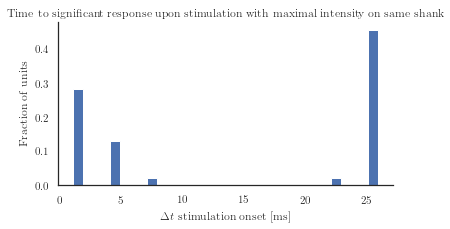

In [130]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
bins = np.arange(1.5, 31.5, 3)
hist, bins = np.histogram(t_max_same, bins)
hist = hist / len(t_max_same)
ax.bar(bins[:-1], hist)
despine(ax)
ax.set_title('Time to significant response upon stimulation with maximal intensity on same shank')
ax.set_xlabel(r'$\Delta t$ stimulation onset [ms]')
ax.set_ylabel('Fraction of units')
plt.show()

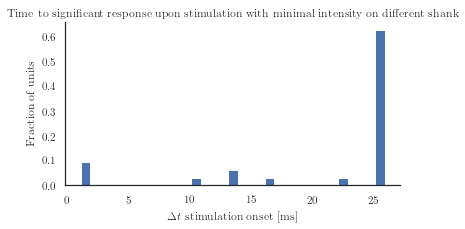

In [133]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
bins = np.arange(1.5, 31.5, 3)
hist, bins = np.histogram(t_min_diff, bins)
hist = hist / len(t_min_diff)
ax.bar(bins[:-1], hist)
despine(ax)
ax.set_title('Time to significant response upon stimulation with minimal intensity on different shank')
ax.set_xlabel(r'$\Delta t$ stimulation onset [ms]')
ax.set_ylabel('Fraction of units')
plt.show()

### Observation
Stimulation on a different shank leads only in very few cases to a significant reaction in a reasonable time frame.

## Calculate IV
We calculate the wald estimate ofor those stimulations that show a significant response within the IV window.

In [171]:
windw = iv_window.rescale(df_stim['first_bin_sig'].values[0].units).magnitude[np.newaxis][0]
df_sigstim = df_stim[df_stim['first_bin_sig'] <= windw]


In [174]:
df_sigstim['intens_mean'] = df_sigstim['intens_mean'].astype(int)
group_sigstim = df_sigstim.groupby(['animal', 'date', 'shank_unit', 'cluster', 'shank_stim'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


38     1304.0
43     1304.0
63     1303.0
85     1302.0
109    1300.0
111    1300.0
146    1308.0
172    1307.0
207    1301.0
243    1294.0
257    1794.0
264    1091.0
265    1091.0
267    1091.0
268    1091.0
269    1091.0
270    1091.0
271    1091.0
272    1091.0
273    1091.0
274    1091.0
275    1091.0
276    1091.0
277    1091.0
278     124.0
279     124.0
280     124.0
281     124.0
283     124.0
284     124.0
        ...  
345    1047.0
346    1047.0
347    1047.0
348    1044.0
349    1044.0
350    1044.0
351    1044.0
352    1044.0
353    1044.0
356     443.0
359     441.0
362     493.0
363     493.0
365     493.0
366     439.0
367     439.0
368     439.0
369     439.0
370     434.0
371     434.0
372     434.0
373     434.0
377     153.0
381     495.0
382     492.0
383     492.0
385     492.0
389     492.0
393     490.0
397     485.0
Name: n_stims, Length: 114, dtype: float64

In [288]:
df_iv = tls_exp.calculate_iv_sigstim(
    blks,
    df_sigstim,
    iv_min_n_stim,
    iv_window,
    iv_ltnc,
    condition_annot_pre={'tagged': True},
    condition_annot_post={'tagged': False})

camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


### Calculate CCH estimate
We calculate the so called transmission probability, the CCH estimate of synaptic coupling.

In [ ]:
df_cch_all = tls_exp.calculate_transmission_prob(
    blks,
    ccg_time_limit,
    ccg_binsize,
    ccg_hollow_fraction,
    ccg_width,
    ccg_sig_level_causal,
    ccg_sig_level_fast,
    ccg_peak_wndw,
    condition_annot_pre={'tagged': True},
    condition_annot_post={'tagged': False})
df_cch_all.rename(columns={'transprob': 'transproball',
                            'bool_cnnctd': 'boolcnnctdall'}, inplace=True)

For curiosity we do it also for only spikes that arised spontaneously and the first evoked spikes

In [22]:
blks_nostim = tls_exp.keep_spikes_by_stim(blks, keep='nostim')

In [23]:
df_cch_nostim = tls_exp.calculate_transmission_prob(
    blks_nostim,
    ccg_time_limit,
    ccg_binsize,
    ccg_hollow_fraction,
    ccg_width,
    ccg_sig_level_causal,
    ccg_sig_level_fast,
    ccg_peak_wndw, 
    condition_annot_pre={'tagged': True},
    condition_annot_post={'tagged': False})
df_cch_nostim.rename(
    columns={'transprob': 'transprobspont',
             'bool_cnnctd': 'boolcnnctdspont'},
    inplace=True)

camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


In [24]:
    blks_stim = tls_exp.select_only_first_spike(
        blks,
        condition_annot_unit={'tagged': True})

In [25]:
df_cch_stim = tls_exp.calculate_transmission_prob(
    blks_stim,
    ccg_time_limit,
    ccg_binsize,
    ccg_hollow_fraction,
    ccg_width,
    ccg_sig_level_causal,
    ccg_sig_level_fast,
    ccg_peak_wndw,
    condition_annot_pre={'tagged': True},
    condition_annot_post={'tagged': False})
df_cch_stim.rename(columns={'transprob': 'transprobevoked',
                            'bool_cnnctd': 'boolcnnctdevoked'}, inplace=True)

camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


In [326]:
df_cch = pd.merge(df_iv, df_cch_nostim,
    on=['animal','date',
        'shank_pre', 'cluster_pre',
       'shank_post','cluster_post'])
df_cch = pd.merge(df_cch, df_cch_stim,
    on=['animal','date',
        'shank_pre', 'cluster_pre',
        'shank_post','cluster_post'])
#df_cch = pd.merge(df_iv, df_cch_stim,
#    on=['animal','date',
#        'shank_pre', 'cluster_pre',
#       'shank_post','cluster_post'])
df_cch = pd.merge(df_cch, df_cch_all,
    on=['animal','date',
        'shank_pre', 'cluster_pre',
        'shank_post','cluster_post'])

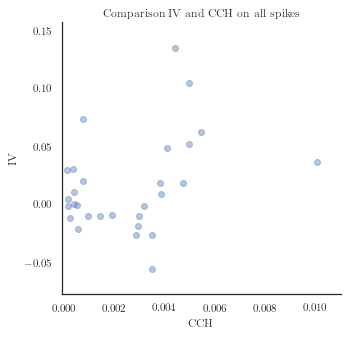

In [290]:
fig, ax = plt.subplots(1, figsize=(5,5))

#ax.set(xscale="log", yscale="log")

ax.scatter(df_cch.loc[df_cch['boolcnnctdall']==True]['transproball'],
           df_cch.loc[df_cch['boolcnnctdall']==True]['ivwald'],
          c='b',
          alpha=0.4)
#ax.scatter(df_cch['transproball'],
#           df_cch['ivwald'],
#          c='r',
#          alpha=0.1)
ax.set_xlabel(r'CCH')
ax.set_ylabel(r'IV')
ax.set_xlim([-0.0001, 0.011])
#ax.set_ylim([-0.03, 0.125])
despine(ax)
ax.set_title('Comparison IV and CCH on all spikes')
plt.show()
fig.tight_layout(rect=[0, 0.00, 1, 1])
#fig.savefig('manuscript/Optodata_comparisonIV_CCH.svg')


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


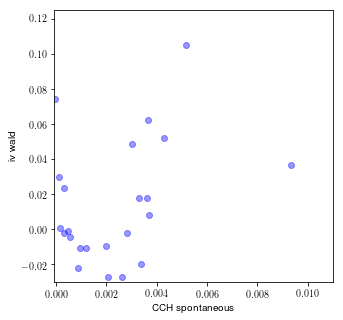

In [41]:
fig, ax = plt.subplots(1, figsize=(5,5))

#ax.set(xscale="log", yscale="log")

ax.scatter(df_cch.loc[df_cch['boolcnnctdspont']==True]['transprobspont'],
           df_cch.loc[df_cch['boolcnnctdspont']==True]['ivwald'],
          c='b',
          alpha=0.4)
ax.set_xlim([-0.0001, 0.011])
ax.set_ylim([-0.03, 0.125])
ax.set_xlabel(r'CCH spontaneous')
ax.set_ylabel(r'iv wald')
ax.set_title('Comparison IV and CCH on spontaneous spikes')
despine(ax)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


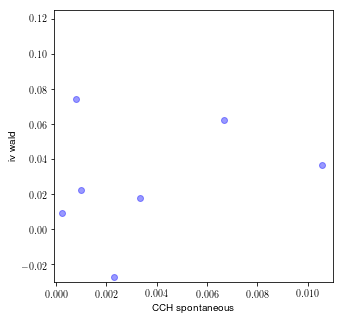

In [42]:
fig, ax = plt.subplots(1, figsize=(5,5))

#ax.set(xscale="log", yscale="log")

ax.scatter(df_cch.loc[df_cch['boolcnnctdevoked']==True]['transprobevoked'],
           df_cch.loc[df_cch['boolcnnctdevoked']==True]['ivwald'],
          c='b',
          alpha=0.4)
ax.set_xlim([-0.0001, 0.011])
ax.set_ylim([-0.03, 0.125])
ax.set_xlabel(r'CCH spontaneous')
ax.set_ylabel(r'iv wald')
ax.set_title('Comparison IV and CCH on first evoked spike only')
despine(ax)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


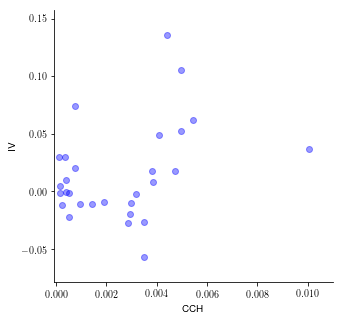

/opt/conda/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/opt/conda/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (67) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/opt/conda/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (72) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/opt/conda/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot 

In [356]:
group_df_pre = df_cch[
    ['animal', 'date', 'shank_pre', 'cluster_pre']
].groupby(['animal', 'date', 'shank_pre']).nunique()
group_df_pre

animal  date  shank_pre  cluster_pre
animal  date     shank_pre                                      
camkii4 20160823 3               1     1          1            1
                 4               1     1          1            1
        20160824 4               1     1          1           14
camkii5 20161004 2               1     1          1            1

In [354]:
group_df_post = df_cch[
    ['animal', 'date', 'shank_post', 'cluster_post']
].groupby(
    ['animal', 'date', 'shank_post'])
group_df_post.nunique()

animal  date  shank_post  cluster_post
animal  date     shank_post                                        
camkii4 20160823 1                1     1           1             3
                 2                1     1           1             5
                 3                1     1           1            15
                 4                1     1           1             5
        20160824 1                1     1           1             2
                 2                1     1           1             5
                 3                1     1           1            26
                 4                1     1           1             4
camkii5 20161004 1                1     1           1            11
                 2                1     1           1             9
                 3                1     1           1             1

In [343]:
#with open('session_expdata.tex','w') as tf:
#    tf.write(group_sigstim['intens_mean'].unique().to_latex())
group_sigstim['intens_mean'].unique()

animal   date      shank_unit  cluster  shank_stim
camkii4  20160823  3.0         15.0     4.0                                         [2063]
                               18.0     3.0                                         [2203]
                               21.0     3.0                                         [2062]
                               22.0     3.0                                         [2203]
                               28.0     3.0                                   [1775, 1922]
                   4.0         6.0      3.0                                         [1775]
                                        4.0                                         [2165]
                               10.0     4.0                                         [1784]
                               11.0     4.0                                         [1895]
         20160824  4.0         2.0      4.0           [2048, 2084, 2124, 2188, 2266, 2333]
                               6.0     

## Correlation of IV and CCH estimate

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


pValue: 0.06932153020550676


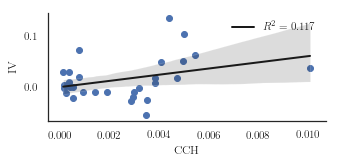

In [291]:
fig, ax = plt.subplots(1,1)
res =tls_exp.regplot('transproball', 'ivwald',
                df_cch.loc[df_cch['boolcnnctdall']==True],
                sm.OLS, colorbar=False, xlabel=r'CCH',
                ylabel=r'IV', ax=ax)
print('pValue: ' + str(res.f_pvalue))


In [292]:
df_cch.corr()

,ivwald,hitrate_stim,Ysr,transprobspont,transprobevoked,transproball
ivwald,1.000000,0.017039,NaN,0.229003,0.187892,0.235688
hitrate_stim,0.017039,1.000000,NaN,-0.014206,-0.029790,-0.018224
Ysr,NaN,NaN,NaN,NaN,NaN,NaN
transprobspont,0.229003,-0.014206,NaN,1.000000,0.808243,0.971891
transprobevoked,0.187892,-0.029790,NaN,0.808243,1.000000,0.857711
transproball,0.235688,-0.018224,NaN,0.971891,0.857711,1.000000


### Observation
We find that there is a weak correlation between iv and the cch estimate of $0.24$.

### Autocorrelation of presynaptic units
Because of slow stimulation onset we used a relatively long iv window.
We want to see how this compares to the refractory period of pyramidal cells.

In [46]:
autocorr_dict = {}
units_pre = df_cch.loc[df_cch['boolcnnctdall']==True].groupby(
    ['animal', 'date', 'shank_pre', 'cluster_pre']
).apply(list).to_dict()
for animal, date, shank_pre, cluster_pre in units_pre.keys():
    for blk in blks:
        units = blk.channel_indexes[0].children
        if blk.annotations['date'] == date and blk.annotations['animal'] == animal:
            unit_i = [unit for unit in units if
                      unit.annotations['shank'] == shank_pre and
                      unit.annotations['cluster'] == cluster_pre][0]
            spktr=unit_i.spiketrains[0]
            cnt, bins_autocorr = correlogram(
                spktr, auto=True,
                limit=autocorr_limit,
                binsize=autocorr_binsize,
                density=True)
            autocorr_dict[animal + '_' + date + '_' 
                          +str(shank_pre) +'_'+ str(cluster_pre)] = cnt

In [47]:
autocorr = np.array(list(chain(autocorr_dict.values())))

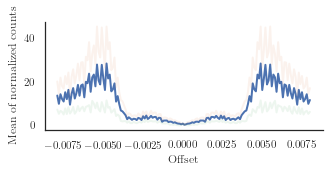

In [347]:
fig, ax = plt.subplots(1)
autocorr_mean = np.mean(autocorr, axis=0)
autocorr_std = np.std(autocorr, axis=0)

ax.plot(bins_autocorr, autocorr_mean)
ax.plot(bins_autocorr, autocorr_mean+autocorr_std, alpha=0.1)
ax.plot(bins_autocorr, autocorr_mean-autocorr_std, alpha=0.1)

ax.set_ylabel(r'Mean of normalized counts')
ax.set_xlabel(r'Offset')
despine(ax)
savefig(fig, fname='Optodata_autocorrelation.svg')

### Observation
The average of the scaled autocorrelogram indicates a refractory period of around $4 ms$

## Bootstrapping
To test the uncertainty of each IV and CCH estimate, we perform bootstrapping with a sample size of $1000$

#### CCH
We use the additive property of the cross correlation function.
We calculate the CCH on chunks of spike trains.
We then randomly pick chunks with replacement, add them up and perform CCH estimation.

#### IV
We first find all onsets and classify whether they contain a spike or not.
Then we randomly pick onsets with replacement.

In [52]:
# Consider only significant connections
# for bootstrapping
conns_sel = list(
    df_cch.loc[df_cch['boolcnnctdall']==True].groupby(
    ['animal', 'date', 'shank_pre', 'cluster_pre', 'shank_post', 'cluster_post']
    ).apply(list).to_dict())

In [54]:
calculate_df_btstrp_cch = True

if calculate_df_btstrp_cch:
    df_btstrp_cch = tls_exp.bootstrap_cch(
            blks, btstrp_n,
            btstrp_binsize,                                                                                                                                                                                            
            ccg_binsize,                                                                                                                                                                                               
            ccg_hollow_fraction,                                                                                                                                                                                       
            ccg_peak_wndw,                                                                                                                                                                                             
            ccg_time_limit,
            ccg_width,
            conns_sel=conns_sel)
    df_btstrp_cch.to_pickle('df_btstrp_cch')
else:
    df_btstrp_cch = pd.read_pickle('df_btstrp_cch')



  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [01:50<51:41, 110.76s/it]

  7%|▋         | 2/29 [03:53<51:26, 114.32s/it]

 10%|█         | 3/29 [06:28<54:48, 126.48s/it]

 14%|█▍        | 4/29 [10:44<1:08:53, 165.36s/it]

 17%|█▋        | 5/29 [16:18<1:26:24, 216.04s/it]

 21%|██        | 6/29 [33:56<2:59:36, 468.52s/it]

 24%|██▍       | 7/29 [46:51<3:25:30, 560.48s/it]

 28%|██▊       | 8/29 [51:59<2:49:39, 484.74s/it]

 31%|███       | 9/29 [54:18<2:07:01, 381.09s/it]

 34%|███▍      | 10/29 [1:02:15<2:09:48, 409.92s/it]

 38%|███▊      | 11/29 [1:03:42<1:33:51, 312.86s/it]

 41%|████▏     | 12/29 [1:09:23<1:31:05, 321.50s/it]

 45%|████▍     | 13/29 [1:11:00<1:07:45, 254.09s/it]

 48%|████▊     | 14/29 [1:14:50<1:01:41, 246.75s/it]

 52%|█████▏    | 15/29 [1:22:33<1:12:43, 311.68s/it]

 55%|█████▌    | 16/29 [1:46:56<2:22:21, 657.06s/it]

 59%|█████▊    | 17/29 [3:53:48<9:08:41, 2743.45s/it]

 62%|██████▏   | 18/29 [3:56:47<6:01:56, 1974.19s/it]

 66%|██████▌   | 

In [55]:
calculate_df_btstrp_iv = True

if calculate_df_btstrp_iv:
    df_btstrp_iv = tls_exp.bootstrap_iv(
            blks, btstrp_n,                                                                                                                                                                                                   
            df_sigstim,                                                                                                                                                                                                
            iv_min_n_stim,                                                                                                                                                                                             
            iv_window,                                                                                                                                                                                                 
            iv_ltnc,                                                                                                                                                                                                   
            conns_sel=conns_sel)
    df_btstrp_iv.to_pickle('df_btstrp_iv')
else:
    df_btstrp_iv = pd.read_pickle('df_btstrp_iv')



  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:03<01:41,  3.63s/it]

  7%|▋         | 2/29 [00:07<01:38,  3.64s/it]

 10%|█         | 3/29 [00:10<01:34,  3.64s/it]

 14%|█▍        | 4/29 [00:14<01:32,  3.69s/it]

 17%|█▋        | 5/29 [00:18<01:30,  3.76s/it]

 21%|██        | 6/29 [00:22<01:28,  3.84s/it]

 24%|██▍       | 7/29 [00:26<01:26,  3.92s/it]

 28%|██▊       | 8/29 [00:31<01:25,  4.06s/it]

 31%|███       | 9/29 [00:35<01:23,  4.20s/it]

 34%|███▍      | 10/29 [00:40<01:22,  4.32s/it]

 38%|███▊      | 11/29 [00:45<01:19,  4.44s/it]

 41%|████▏     | 12/29 [00:49<01:17,  4.55s/it]

 45%|████▍     | 13/29 [00:54<01:14,  4.67s/it]

 48%|████▊     | 14/29 [00:59<01:11,  4.80s/it]

 52%|█████▏    | 15/29 [01:05<01:08,  4.92s/it]

 55%|█████▌    | 16/29 [01:10<01:05,  5.03s/it]

 59%|█████▊    | 17/29 [01:15<01:01,  5.13s/it]

 62%|██████▏   | 18/29 [01:21<00:57,  5.24s/it]

 66%|██████▌   | 19/29 [01:26<00:53,  5.35s/it]

 69%|██████▉   | 20/29 [01:32<00:49,

In [72]:
cch_err = []
iv_err = []
for conn in conns_sel:
    (animal,
     date,
     shank_pre,
     cluster_pre,
     shank_post,
     cluster_post) = conn
    df_conn_iv = df_btstrp_iv.loc[
        (df_btstrp_iv['animal'] == animal) &
        (df_btstrp_iv['date'] == date) &
        (df_btstrp_iv['shank_pre'] == shank_pre) &
        (df_btstrp_iv['cluster_pre'] == cluster_pre) &
        (df_btstrp_iv['shank_post'] == shank_post) &
        (df_btstrp_iv['cluster_post'] == cluster_post)]
    iv_err.append(np.nanstd(df_conn_iv['ivwald']))

    df_conn_cch = df_btstrp_cch.loc[
        (df_btstrp_cch['animal'] == animal) &
        (df_btstrp_cch['date'] == date) &
        (df_btstrp_cch['shank_pre'] == shank_pre) &
        (df_btstrp_cch['cluster_pre'] == cluster_pre) &
        (df_btstrp_cch['shank_post'] == shank_post) &
        (df_btstrp_cch['cluster_post'] == cluster_post)]
    cch_err.append(np.nanstd(df_conn_cch['trans_prob']))
iv_err = np.array(iv_err)
cch_err = np.array(cch_err)

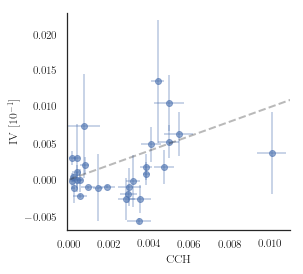

In [76]:
fig, ax = plt.subplots(1, figsize=(4,4))

#ax.set(xscale="log", yscale="log")
x = df_cch.loc[df_cch['boolcnnctdall']==True]['transproball']
y = df_cch.loc[df_cch['boolcnnctdall']==True]['ivwald']
ax.scatter(x,
           y*0.1,
          c='b',
          alpha=0.6)
ax.errorbar(x, y*0.1, xerr=cch_err, yerr=iv_err*0.1, fmt='none', alpha=0.3)
#ax.scatter(df_cch['transproball'],
#           df_cch['ivwald'],
#          c='r',
#          alpha=0.1)
ax.set_xlabel(r'CCH')
ax.set_ylabel(r'IV $[10^{-1}]$')
ax.set_xlim([-0.0001, 0.011])
ax.set_ylim([-0.007, 0.023])
ax.plot([0,1], [0,1], 'k--', alpha=0.3)
despine(ax)
plt.show()
fig.tight_layout(rect=[0, 0.00, 1, 1])
fig.savefig('manuscript/Optodata_comparisonIV_CCH.svg')


### Uncertainty and iv window length
We observed that having a small window size, results in many units having very few spikes after stimulation.
Therefore we expect that small window size results in higher errorbars

In [58]:
# test different iv windows for their error
lst_iv_windows = np.array([1.5, 3., 4.5, 6., 7.5, 9.])*pq.s
lst_df_diffwindw = []
for windw in lst_iv_windows:
    df_i = tls_exp.bootstrap_iv(
            blks, btstrp_n,                                                                                                                                                                                                
            df_sigstim,                                                                                                                                                                                                
            iv_min_n_stim,                                                                                                                                                                                             
            windw,                                                                                                                                                                                                 
            iv_ltnc,
            conns_sel=conns_sel)
    lst_df_diffwindw.append(df_i)




  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:03<01:41,  3.62s/it]

  7%|▋         | 2/29 [00:07<01:38,  3.66s/it]

 10%|█         | 3/29 [00:11<01:35,  3.66s/it]

 14%|█▍        | 4/29 [00:14<01:31,  3.67s/it]

 17%|█▋        | 5/29 [00:18<01:31,  3.80s/it]

 21%|██        | 6/29 [00:22<01:29,  3.89s/it]

 24%|██▍       | 7/29 [00:27<01:29,  4.06s/it]

 28%|██▊       | 8/29 [00:32<01:29,  4.28s/it]

 31%|███       | 9/29 [00:36<01:27,  4.39s/it]

 34%|███▍      | 10/29 [00:41<01:24,  4.47s/it]

 38%|███▊      | 11/29 [00:46<01:21,  4.54s/it]

 41%|████▏     | 12/29 [00:51<01:19,  4.65s/it]

 45%|████▍     | 13/29 [00:56<01:16,  4.77s/it]

 48%|████▊     | 14/29 [01:01<01:13,  4.87s/it]

 52%|█████▏    | 15/29 [01:06<01:09,  4.98s/it]

 55%|█████▌    | 16/29 [01:11<01:06,  5.11s/it]

 59%|█████▊    | 17/29 [01:17<01:02,  5.23s/it]

 62%|██████▏   | 18/29 [01:22<00:58,  5.32s/it]

 66%|██████▌   | 19/29 [01:28<00:54,  5.43s/it]

 69%|██████▉   | 20/29 [01:34<00:49,

 83%|████████▎ | 24/29 [01:56<00:29,  5.99s/it]

 86%|████████▌ | 25/29 [02:03<00:24,  6.10s/it]

 90%|████████▉ | 26/29 [02:09<00:18,  6.22s/it]

 93%|█████████▎| 27/29 [02:16<00:12,  6.40s/it]

 97%|█████████▋| 28/29 [02:23<00:06,  6.57s/it]

100%|██████████| 29/29 [02:30<00:00,  6.77s/it]



  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:03<01:38,  3.53s/it]

  7%|▋         | 2/29 [00:07<01:36,  3.58s/it]

 10%|█         | 3/29 [00:11<01:34,  3.64s/it]

 14%|█▍        | 4/29 [00:14<01:33,  3.73s/it]

 17%|█▋        | 5/29 [00:19<01:38,  4.09s/it]

 21%|██        | 6/29 [00:24<01:37,  4.26s/it]

 24%|██▍       | 7/29 [00:28<01:34,  4.28s/it]

 28%|██▊       | 8/29 [00:33<01:32,  4.38s/it]

 31%|███       | 9/29 [00:38<01:34,  4.71s/it]

 34%|███▍      | 10/29 [00:44<01:35,  5.03s/it]

 38%|███▊      | 11/29 [00:49<01:30,  5.04s/it]

 41%|████▏     | 12/29 [00:54<01:25,  5.03s/it]

 45%|████▍     | 13/29 [00:59<01:20,  5.06s/it]

 48%|████▊     | 14/29 [01:05<01:16,

In [69]:
mean_err = []
for i in range(len(lst_iv_windows)):
    df_i = lst_df_diffwindw[i]
    iv_err = []
    for conn in conns_sel:
        (animal,
         date,
         shank_pre,
         cluster_pre,
         shank_post,
         cluster_post) = conn
        df_conn_iv = df_i.loc[
            (df_i['animal'] == animal) &
            (df_i['date'] == date) &
            (df_i['shank_pre'] == shank_pre) &
            (df_i['cluster_pre'] == cluster_pre) &
            (df_i['shank_post'] == shank_post) &
            (df_i['cluster_post'] == cluster_post)]
        iv_err.append(np.nanstd(df_conn_iv['ivwald']))
    iv_err = np.array(iv_err)
    mean_err.append(np.nanmean(iv_err))

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


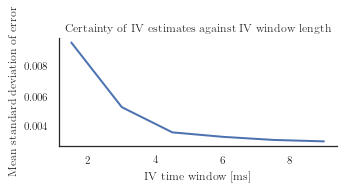

In [77]:
fig, ax = plt.subplots(1)
ax.plot(lst_iv_windows, mean_err)
ax.set_title('Certainty of IV estimates against IV window length')
ax.set_xlabel(r'IV time window [ms]')
ax.set_ylabel(r'Mean standard deviation of error')
despine(ax)
fig.savefig('manuscript/Optodata_error_by_IV_window.svg')
